# Aula 14 - Aprendizado por reforço

Neste notebook iremos implementar algoritmos de aprendizado por reforço utilizando ambientes fornecidos pelo [Open AI Gym](https://www.gymlibrary.ml).

## Parte 1 - Q-learning


Neste exemplo, implementaremos o algoritmo de aprendizado por refoço chamado Q-learning. 

Primeiramente, precisamos importar algumas bibliotecas.

In [36]:
import gym
import numpy as np
import matplotlib.pyplot as plt

Em nosso exemplo, tentaremos resolver o problema chamado Cliff Walking, apresentado na figura abaixo. Neste problema, o agente parte de S e deve chegar em G de uma forma eficiente, mas evitando o penhasco. Para cada passo, o agente recebe uma recompensa de -1. Caso o agente caia no penhasco, a recompensa é -100. O episódio termina quando o agente chega em G ou cai no penhasco. Naturalmente, o objetivo é chegar em G o mais rapidamente possível para maximizar sua recompensa.

![alt text](https://i.imgur.com/2IobMYw.png)

Para utilizar este ambiente com o Gym, basta executar o comando abaixo.

In [37]:
cliff_env = gym.make('CliffWalking-v0')

O ambiente pode ser reiniciado com a função `reset`. Podemos imprimir o estado atual do ambiente com a função `render`.

In [38]:
cliff_env.reset()
cliff_env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



O código abaixo implementa o algoritmo Q-learning. O pseudocódigo do Q-learning é apresentado abaixo.

![alt text](https://i.imgur.com/9yydGca.png)

Em nossa implementação, o algoritmo recebe um ambiente, uma quantidade de episódios, além dos parâmetros usuais $\alpha$ (taxa de aprendizado), $\gamma$ (taxa de desconto) e $\epsilon$ (taxa de exploração).

In [39]:
def Qlearning(environment, num_episodes=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.01):
  
  # initializing the Q-table
  Q = np.zeros((environment.observation_space.n, environment.action_space.n))

  # additional lists to keep track of reward and epsilon values
  rewards = []
  epsilons = []

  # episodes
  for episode in range(num_episodes):
      
      # reset the environment to start a new episode
      state = environment.reset()

      # reward accumulated along episode
      accumulated_reward = 0
      
      # steps within current episode
      for step in range(100):
          
          # epsilon-greedy action selection
          # exploit with probability 1-epsilon
          if np.random.uniform(0, 1) > epsilon:
              action = np.argmax(Q[state,:])
              
          # explore with probability epsilon
          else:
              action = environment.action_space.sample()
              
          # perform the action and observe the new state and corresponding reward
          new_state, reward, done, info = environment.step(action)
          

          # update the Q-table
          Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
          
          # update the accumulated reward
          accumulated_reward += reward

          # update the current state
          state = new_state
          
          # end the episode when it is done
          if done == True:
              break
      
      # decay exploration rate to ensure that the agent exploits more as it becomes experienced
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)
      
      # update the lists of rewards and epsilons
      rewards.append(accumulated_reward)
      epsilons.append(epsilon)

  # render the environment
  environment.render()
    
  # return the list of accumulated reward along episodes
  return rewards

Para utilizar o Q-learning, basta chamá-lo como segue. No exemplo abaixo, vamos executar o algoritmo por 100 episódios. Ao final, calculamos a recompensa média total (ao longo de todos episódios) e a final (ao longo dos últimos 10 episódios).

In [40]:
num_episodes=100
alpha=0.3
gamma=0.9
epsilon=1.0
decay_epsilon=0.1

# run Q-learning
rewards = Qlearning(cliff_env, num_episodes, alpha, gamma, epsilon, decay_epsilon)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 10 episodes): " + str(sum(rewards[-10:])/10))

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

Average reward (all episodes): -116.6
Average reward (last 10 episodes): -13.2


Para avaliar o desempenho do algoritmo, podemos criar um gráfico da recompensa total por episódio.

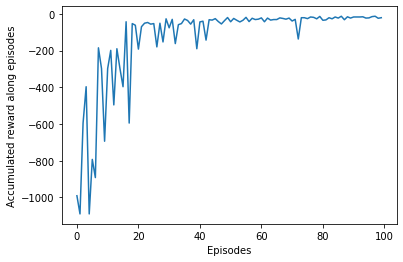

In [6]:
plt.plot(range(num_episodes), rewards)
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward along episodes')
plt.show()

Com base no gráfico acima, podemos observar que o algoritmo converge para uma recompensa próxima de zero. Considerando que a recompensa máxima neste ambiente é -13, podemos dizer que o algoritmo convergiu para uma política próxima da ótima.

## Parte 2 - Deep Q-Networks

Neste exemplo, implementaremos o algoritmo de aprendizado por reforço profundo chamado Deep Q-Networks (DQN). 

Para começar, o código abaixo importa uma série de bibliotecas para facilitar nosso trabalho. Basta executar.

In [1]:
#@title Executar (configurações básicas)

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video_short():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Neste exemplo, utilizaremos o ambiente `CartPole-v0` [link](https://www.gymlibrary.ml/environments/classic_control/cart_pole/). Neste ambiente, existe um carrinho com um poste disposto verticalmente em cima de si, mas caindo para um dos lados (aleatoriamente). Nosso objetivo é mover o carrinho para a esquerda e/ou direita para tentar equilibrar o poste.

Para importar este ambiente, basta executar o código abaixo.

In [2]:
env = wrap_env(gym.make('CartPole-v0'))

O código abaixo facilita o entendimento da dinâmica do ambiente. A cada passo, devemos escoher uma ação e então executá-la no ambiente (usando a função `step`). Ao executar a ação, observamos um novo estado, uma recompensa e outras informações extras. No caso do CartPole-v0, o episódio termina quando o carrinho sair da área de visão ou quando o poste inclinar-se mais do que 15 graus para qualquer lado.

In [3]:
env.reset()
while True:
    env.render( )
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    if done:
      break

env.close()
show_video_short()

Agora podemos implementar o algoritmo DQN. Nossa implementação é baseada [neste post](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998).

In [4]:
import numpy as np
import tensorflow as tf
import gym
import os
import datetime
from statistics import mean


class MyModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='tanh', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output


class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = MyModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))

    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            return 0
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.experience['s'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        states_next = np.asarray([self.experience['s2'][i] for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_mean(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss

    def get_action(self, states, epsilon):
        if np.random.random() < epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.predict(np.atleast_2d(states))[0])

    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())


def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    losses = list()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        rewards += reward
        if done:
            reward = -200
            env.reset()

        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)
        loss = TrainNet.train(TargetNet)
        if isinstance(loss, int):
            losses.append(loss)
        else:
            losses.append(loss.numpy())
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards, mean(losses)

def show_video(env, TrainNet):
  # generate video
  env = Monitor(env, os.path.join(os.getcwd(), "videos"), force=True)
  rewards = 0
  steps = 0
  done = False
  observation = env.reset()
  while not done:
      env.render()
      action = TrainNet.get_action(observation, 0)
      observation, reward, done, _ = env.step(action)
      steps += 1
      rewards += reward
  env.close()
  print("Testing steps: {} rewards {}: ".format(steps, rewards))
  
  # display video
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

O código abaixo treina o DQN no ambiente `CarPole-v0`. Cuidado, pode demorar bastante para executar.

In [ ]:
env = gym.make('CartPole-v0')
gamma = 0.99
copy_step = 25
num_states = len(env.observation_space.sample())
num_actions = env.action_space.n
hidden_units = [200, 200]
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/dqn/' + current_time
summary_writer = tf.summary.create_file_writer(log_dir)

TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
N = 10000
total_rewards = np.empty(N)
epsilon = 0.99
decay = 0.9999
min_epsilon = 0.1
for n in range(N):
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward, losses = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    total_rewards[n] = total_reward
    avg_rewards = total_rewards[max(0, n - 100):(n + 1)].mean()
    with summary_writer.as_default():
        tf.summary.scalar('episode reward', total_reward, step=n)
        tf.summary.scalar('running avg reward(100)', avg_rewards, step=n)
        tf.summary.scalar('average loss)', losses, step=n)
    if n % 100 == 0:
        print("episode:", n, "episode reward:", total_reward, "eps:", epsilon, "avg reward (last 100):", avg_rewards,
              "episode loss: ", losses)
print("avg reward for last 100 episodes:", avg_rewards)

Finalmente, podemos ver o resultado gerando um vídeo da execução do algoritmo treinado no ambiente.

In [ ]:
show_video(env, TrainNet)

Testing steps: 89 rewards 89.0: 


Note que o resultado não é muito satisfatório. Para melhorar o resultado, é preciso ajustar os hiper-parâmetros do algoritmo e treiná-lo novamente.

## Exercícios

### Exercício 1

Ajuste os parâmetros do algoritmo Q-learning para obter melhores resultados. Em seguida, rode o algoritmo com a melhor política aprendida, ou seja, escolhendo as ações de forma gulosa.

Aumentando os número de episódios e o parâmetro alpha o desempenho é melhorado.

In [24]:
num_episodes=200
alpha=0.5
gamma=0.9
epsilon=1.0
decay_epsilon=0.1

# run Q-learning
rewards = Qlearning(cliff_env, num_episodes, alpha, gamma, epsilon, decay_epsilon)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 10 episodes): " + str(sum(rewards[-10:])/10))

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

Average reward (all episodes): -63.07
Average reward (last 10 episodes): -13.3


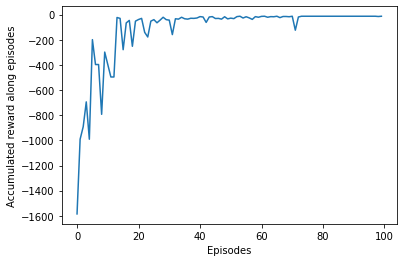

In [41]:
plt.plot(range(num_episodes), rewards)
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward along episodes')
plt.show()

### Exercício 2 (extra)

Ajuste os parâmetros do algoritmo DQN para obter melhores resultados no ambiente `CartPole-v0`.

In [6]:
env = gym.make('CartPole-v0')
gamma = 0.999
copy_step = 25
num_states = len(env.observation_space.sample())
num_actions = env.action_space.n
hidden_units = [200, 200]
max_experiences = 10000
min_experiences = 100
batch_size = 128
lr = 1e-2
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/dqn/' + current_time
summary_writer = tf.summary.create_file_writer(log_dir)

TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
N = 10000
total_rewards = np.empty(N)
epsilon = 0.9
decay = 200
min_epsilon = 1.0
for n in range(N):
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward, losses = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    total_rewards[n] = total_reward
    avg_rewards = total_rewards[max(0, n - 100):(n + 1)].mean()
    with summary_writer.as_default():
        tf.summary.scalar('episode reward', total_reward, step=n)
        tf.summary.scalar('running avg reward(100)', avg_rewards, step=n)
        tf.summary.scalar('average loss)', losses, step=n)
    if n % 100 == 0:
        print("episode:", n, "episode reward:", total_reward, "eps:", epsilon, "avg reward (last 100):", avg_rewards,
              "episode loss: ", losses)
print("avg reward for last 100 episodes:", avg_rewards)

episode: 0 episode reward: 11.0 eps: 180.0 avg reward (last 100): 11.0 episode loss:  0
episode: 100 episode reward: 16.0 eps: 2.2817710804108116e+232 avg reward (last 100): 22.019801980198018 episode loss:  76.2756
episode: 200 episode reward: 27.0 eps: inf avg reward (last 100): 21.702970297029704 episode loss:  73.88757
episode: 300 episode reward: 16.0 eps: inf avg reward (last 100): 24.405940594059405 episode loss:  69.75513
episode: 400 episode reward: 32.0 eps: inf avg reward (last 100): 21.336633663366335 episode loss:  147.57957
episode: 500 episode reward: 11.0 eps: inf avg reward (last 100): 21.623762376237625 episode loss:  117.58608
episode: 600 episode reward: 27.0 eps: inf avg reward (last 100): 22.396039603960396 episode loss:  646.0461
episode: 700 episode reward: 30.0 eps: inf avg reward (last 100): 19.782178217821784 episode loss:  155.23718
episode: 800 episode reward: 30.0 eps: inf avg reward (last 100): 21.792079207920793 episode loss:  287.7146
episode: 900 episo